In [2]:
import os
from pathlib import Path
import time
import json

import torch
from datasets import load_dataset, Audio
import IPython.display
import librosa
from pyannote.audio import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# dataset = load_dataset('yodas_ru000_128k_filtered', data_files='00000-of-00177.parquet', split='train').cast_column('audio', Audio(decode=True))
# IPython.display.Audio(waveform, rate=sr)

In [ ]:
# import torch
# torch.backends.cuda.matmul.allow_tf32 = True
# torch.backends.cudnn.allow_tf32 = True

In [ ]:
from pyannote.audio.pipelines import SpeakerDiarization

# this is a replication of what happens inside the call
# `pyannote.audio.Pipeline.from_pretrained('pyannote/speaker-diarization-3.1')`

pipeline = SpeakerDiarization(
    segmentation='pyannote/segmentation-3.0',
    segmentation_batch_size=256,
    embedding='speechbrain/spkrec-ecapa-voxceleb', # 'pyannote/wespeaker-voxceleb-resnet34-LM', #
    embedding_batch_size=128,
    clustering='AgglomerativeClustering',
    embedding_exclude_overlap=True,
    use_auth_token=os.getenv('HF_TOKEN'),
).instantiate({
    'clustering': {
        'method': 'centroid',
        'min_cluster_size': 12,
        'threshold': 0.7045654963945799,
    },
    'segmentation': {
        'min_duration_off': 0.0,
    },
}).to(torch.device('cuda'))

In [ ]:
dir = Path('yodas2_ru000_32k/audio')

audio_filenames = sorted(dir.glob('*.mp3'))[:70]
# audio_paths = [
#     'sf-MgjReBrE.mp3',
#     'F3GOKxjKbvY.mp3',
#     'VDHcOxoIBWy.mp3',
#     '3LIgXgrc0xY.mp3',
#     'FmgR5SOwh-Y.mp3',
#     'NBWUhup0zyU.mp3',
#     'GJBjyS0ryMg.mp3',
#     'cJwgh_hoEMU.mp3',
#     'dVXC3lzamwc.mp3',
#     'rYaQOhPWYpy.mp3',
#     'o1Me9emSIUQ.mp3',
#     'soAWYl2aal0.mp3',
#     '7-cUL28TL-u.mp3',
#     'yCwlZxBK0-k.mp3',
#     'QZBQ-aHeVXk.mp3',
# ]

for i, audio_path in enumerate(audio_filenames):
    
    save_path = Path(f'results/{audio_path.name}.txt')

    if save_path.is_file():
        continue

    results = []
    waveform, sampling_rate = librosa.load(audio_path, sr=16_000)
    n_sec = len(waveform) / sampling_rate
    max_repeats = min(10, int(30 * 60 // n_sec))
    
    print(f'{i} {audio_path}, {n_sec:.1f} seconds, max repeats {max_repeats}')

    for n_repeats in range(1, max_repeats + 1):
        start_time = time.time()
        annotation = pipeline({
            'waveform': torch.tensor(np.concatenate([waveform] * n_repeats))[None],
            'sample_rate': sampling_rate
        })
        n_speakers = len(annotation.labels())
        results.append(result := {
            'audio': str(audio_path),
            'audio_len': n_sec,
            'repeats': n_repeats,
            'n_speakers': n_speakers,
            'elapsed': time.time() - start_time,
        })
        print(i, result)

    save_path.write_text(json.dumps(results))

In [ ]:
annotation, embeddings = pipeline.apply({'waveform': torch.tensor(waveform)[None], 'sample_rate': sr}, return_embeddings=True)
results_list = [
    {'start': turn.start, 'end': turn.end, 'speaker_idx': annotation.labels().index(speaker)}
    for turn, _, speaker in annotation.itertracks(yield_label=True)
]
results_list[:5]
embeddings.shape

In [40]:
results = pd.DataFrame(sum([
    json.loads(f.read_text())
    for f in Path('results').glob('*.txt')
], []))
results['total_len'] = results['audio_len'] * results['repeats']
results['audio'] = [x.split('/')[-1] for x in results['audio']]
results

,audio,audio_len,repeats,n_speakers,elapsed,total_len
0,-HUYTbRmi0I.mp3,226.487500,1,1,1.546692,226.487500
1,-HUYTbRmi0I.mp3,226.487500,2,1,3.142208,452.975000
2,-HUYTbRmi0I.mp3,226.487500,3,1,4.724838,679.462500
3,-HUYTbRmi0I.mp3,226.487500,4,2,6.315155,905.950000
4,-HUYTbRmi0I.mp3,226.487500,5,1,7.911699,1132.437500
...,...,...,...,...,...,...
420,-2Gl8Yry5PM.mp3,131.842938,6,1,5.013928,791.057625
421,-2Gl8Yry5PM.mp3,131.842938,7,1,5.683793,922.900562
422,-2Gl8Yry5PM.mp3,131.842938,8,1,6.371395,1054.743500
423,-2Gl8Yry5PM.mp3,131.842938,9,1,7.076249,1186.586438


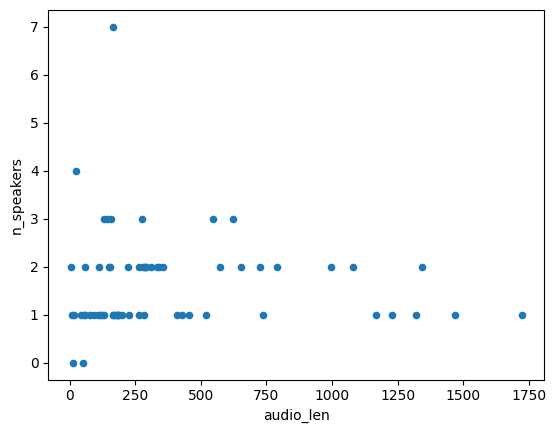

In [45]:
results[results['repeats'] == 1].plot.scatter('audio_len', 'n_speakers');

In [41]:
results.pivot_table(values='n_speakers', index='audio', columns='repeats').astype(pd.Int64Dtype).astype(str).replace('<NA>', '')

/tmp/ipykernel_20603/1930657457.py:1: UserWarning: Instantiating Int64Dtype without any arguments.Pass a Int64Dtype instance to silence this warning.
  results.pivot_table(values='n_speakers', index='audio', columns='repeats').astype(pd.Int64Dtype).astype(str).replace('<NA>', '')


repeats,1,2,3,4,5,6,7,8,9,10
audio,,,,,,,,,,
--0Iayku3EM.mp3,2,3,5,5,6,,,,,
--CIplNkfL4.mp3,1,1,1,1,1,1,1,1,1,
--GF_VxKQW0.mp3,2,8,,,,,,,,
--_Rr6hNbo0.mp3,3,14,15,17,19,19,20,21,22,22
-18w02Fwn3E.mp3,1,2,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...
-KBo9kYwY1M.mp3,3,10,15,15,16,16,,,,
-KdWLic1CRE.mp3,2,7,8,9,9,10,12,12,10,12
-Ku7TDX-xWy.mp3,2,,,,,,,,,


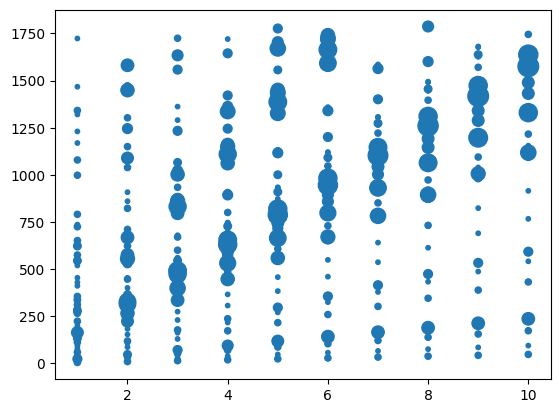

In [19]:
plt.scatter(results['repeats'], results['total_len'], s=results['n_speakers'] * 10)

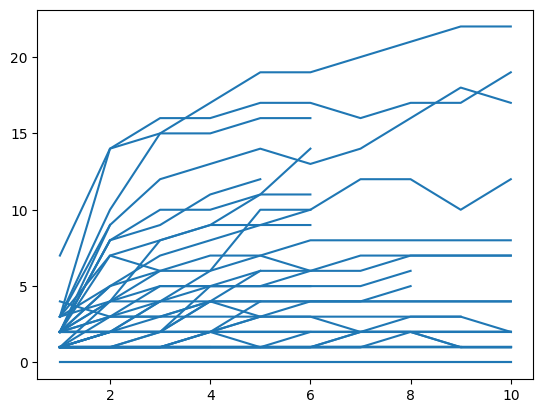

In [32]:
for audio, group_indices in results.groupby('audio').groups.items():
    group = results.loc[group_indices]
    plt.plot(group['repeats'], group['n_speakers'], color='C0')